# LSTM Text Classification - IMDB Sentiment Analysis

**Group 9 - Text Classification Project (Member 3)**

- **Dataset:** IMDB Movie Reviews
- **Model:** Long Short-Term Memory (LSTM)
- **Embeddings:** TF-IDF, GloVe, Word2Vec

This notebook demonstrates the implementation and training of LSTM models using three different embedding techniques.


## 1. Setup and Imports


In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Add src to path
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT / "src"))

from preprocessing import load_imdb_data, preprocess_dataset, split_data
from evaluation import evaluate_model, print_evaluation_report

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")
print(f"Project Root: {PROJECT_ROOT}")


TensorFlow Version: 2.16.2
Project Root: /Users/gustav/Documents/Alu/Group_9_Text_classification


## 2. Data Loading & Preprocessing

We use the shared preprocessing pipeline to load and clean the IMDB dataset.


In [2]:
# Load data
data_path = PROJECT_ROOT / "data" / "raw" / "IMDB Dataset.csv"
df = load_imdb_data(str(data_path))

# Preprocess (stopwords removal is model-dependent, handled below)
print(f"Loaded {len(df)} reviews")
df.head()


Loading data from /Users/gustav/Documents/Alu/Group_9_Text_classification/data/raw/IMDB Dataset.csv...
Loaded 50000 reviews
Columns: ['review', 'sentiment']
Loaded 50000 reviews


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Model 1: LSTM with TF-IDF

TF-IDF vectors are used as input features. Since LSTM expects a sequence, we reshape the TF-IDF vector to `(samples, 1, features)`.


In [3]:
from models.lstm_tfidf import create_tfidf_sequences, build_lstm_tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF requires stopwords removal for better performance
df_tfidf = preprocess_dataset(df.copy(), remove_stopwords=True)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_tfidf)

# Create features
print("Creating TF-IDF features...")
X_train_seq, X_val_seq, X_test_seq, vectorizer = create_tfidf_sequences(
    X_train, X_val, X_test, max_features=5000
)

print(f"Input shape: {X_train_seq.shape}")

# Build and Train
model_tfidf = build_lstm_tfidf((X_train_seq.shape[1], X_train_seq.shape[2]))
model_tfidf.summary()

history_tfidf = model_tfidf.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,  # Reduced for demonstration
    batch_size=64,
    verbose=1
)


Preprocessing dataset...
Preprocessing complete. 50000 reviews processed.

Splitting data...
Test size: 20.0%, Validation size: 10.0%
Training set: 35000 samples (70.0%)
Validation set: 5000 samples (10.0%)
Test set: 10000 samples (20.0%)

Class distribution:
Train - Negative: 17500, Positive: 17500
Val   - Negative: 2500, Positive: 2500
Test  - Negative: 5000, Positive: 5000
Creating TF-IDF features...
Input shape: (35000, 1, 5000)


2026-02-09 10:26:07.631119: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2026-02-09 10:26:07.631461: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-09 10:26:07.631466: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-09 10:26:07.631774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-09 10:26:07.631828: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/gustav/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Seque

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │     1,296,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,298,753 (4.95 MB)

 Trainable params: 1,298,753 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


2026-02-09 10:26:10.536820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.7957 - loss: 0.4654 - val_accuracy: 0.8916 - val_loss: 0.2618
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.9052 - loss: 0.2401 - val_accuracy: 0.8858 - val_loss: 0.2732
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9163 - loss: 0.2228 - val_accuracy: 0.8838 - val_loss: 0.2840
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.9243 - loss: 0.2128 - val_accuracy: 0.8796 - val_loss: 0.2972
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.9292 - loss: 0.2044 - val_accuracy: 0.8786 - val_loss: 0.3036


### TF-IDF Results


In [4]:
# Evaluate
y_prob = model_tfidf.predict(X_test_seq).flatten()
y_pred = (y_prob > 0.5).astype(int)
metrics_tfidf = evaluate_model(y_test, y_pred, y_prob)
print_evaluation_report(metrics_tfidf, "LSTM + TF-IDF")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

  LSTM + TF-IDF - Evaluation Results
  Accuracy:  0.8831
  Precision: 0.8894
  Recall:    0.8750
  F1-Score:  0.8821
  ROC-AUC:   0.9539



## 4. Model 2: LSTM with GloVe Embeddings

Using pre-trained GloVe vectors (100d) to initialize the Embedding layer.


In [5]:
from models.lstm_glove import load_glove, build_embedding_matrix, build_lstm_glove
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load GloVe
glove_path = PROJECT_ROOT / "data" / "embeddings" / "glove.6B.100d.txt"
embeddings_index = load_glove(str(glove_path))
embed_dim = 100

# Preprocess (keep stopwords for sequence models)
df_glove = preprocess_dataset(df.copy(), remove_stopwords=False)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_glove)

# Tokenize
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

maxlen = 300
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=maxlen)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)

# Embedding Matrix
embedding_matrix, vocab_size = build_embedding_matrix(tokenizer, embeddings_index, embed_dim)

# Build and Train
model_glove = build_lstm_glove(vocab_size, embed_dim, embedding_matrix, maxlen)
model_glove.summary()

history_glove = model_glove.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)


Loading GloVe embeddings from /Users/gustav/Documents/Alu/Group_9_Text_classification/data/embeddings/glove.6B.100d.txt...
Preprocessing dataset...
Preprocessing complete. 50000 reviews processed.

Splitting data...
Test size: 20.0%, Validation size: 10.0%
Training set: 35000 samples (70.0%)
Validation set: 5000 samples (10.0%)
Test set: 10000 samples (20.0%)

Class distribution:
Train - Negative: 17500, Positive: 17500
Val   - Negative: 2500, Positive: 2500
Test  - Negative: 5000, Positive: 5000
  Vocabulary size: 170,990
  Out-of-vocabulary words: 102,490 (59.94%)


/Users/gustav/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    17,099,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,099,000 (65.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,099,000 (65.23 MB)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.6140 - loss: 0.6464 - val_accuracy: 0.7862 - val_loss: 0.4490
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - accuracy: 0.7950 - loss: 0.4530 - val_accuracy: 0.8162 - val_loss: 0.4122
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - accuracy: 0.8299 - loss: 0.3883 - val_accuracy: 0.8564 - val_loss: 0.3463
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - accuracy: 0.8481 - loss: 0.3488 - val_accuracy: 0.8658 - val_loss: 0.3193
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - accuracy: 0.8592 - loss: 0.3279 - val_accuracy: 0.8680 - val_loss: 0.3204


### GloVe Results


In [7]:
# Evaluate
y_prob = model_glove.predict(X_test_seq).flatten()
y_pred = (y_prob > 0.5).astype(int)
metrics_glove = evaluate_model(y_test, y_pred, y_prob)
print_evaluation_report(metrics_glove, "LSTM + GloVe")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

  LSTM + GloVe - Evaluation Results
  Accuracy:  0.8704
  Precision: 0.8849
  Recall:    0.8516
  F1-Score:  0.8679
  ROC-AUC:   0.9432



## 5. Model 3: LSTM with Word2Vec

Training a custom Word2Vec model on the IMDB corpus.


In [8]:
from models.lstm_word2vec import train_word2vec, build_lstm_word2vec
# Note: Reuse tokenizer logic or import specific functions if needed
# For demo, we'll assume a similar flow but with custom embeddings

# Preprocess (keep stopwords)
df_w2v = preprocess_dataset(df.copy(), remove_stopwords=False)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_w2v)

# Train Word2Vec
w2v_model = train_word2vec(X_train, vector_size=100, window=5, min_count=2)

# Prepare Tokenizer matching Word2Vec vocab
tokenizer_w2v = Tokenizer()
w2v_vocab = w2v_model.wv.key_to_index
tokenizer_w2v.word_index = {word: i+1 for word, i in w2v_vocab.items()}
tokenizer_w2v.num_words = len(w2v_vocab) + 1

X_train_seq = pad_sequences(tokenizer_w2v.texts_to_sequences(X_train), maxlen=300)
X_val_seq = pad_sequences(tokenizer_w2v.texts_to_sequences(X_val), maxlen=300)
X_test_seq = pad_sequences(tokenizer_w2v.texts_to_sequences(X_test), maxlen=300)

# Build Embedding Matrix
vocab_size = len(tokenizer_w2v.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer_w2v.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Build and Train
model_w2v = build_lstm_word2vec(vocab_size, 100, embedding_matrix, 300)
model_w2v.summary()

history_w2v = model_w2v.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)


Preprocessing dataset...
Preprocessing complete. 50000 reviews processed.

Splitting data...
Test size: 20.0%, Validation size: 10.0%
Training set: 35000 samples (70.0%)
Validation set: 5000 samples (10.0%)
Test set: 10000 samples (20.0%)

Class distribution:
Train - Negative: 17500, Positive: 17500
Val   - Negative: 2500, Positive: 2500
Test  - Negative: 5000, Positive: 5000
Training Word2Vec (Skip-gram)...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

  Word2Vec vocabulary size: 67,841
  Vector dimension: 100


/Users/gustav/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     6,784,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,784,200 (25.88 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,784,200 (25.88 MB)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.7183 - loss: 0.5491 - val_accuracy: 0.8510 - val_loss: 0.3533
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.8417 - loss: 0.3804 - val_accuracy: 0.8356 - val_loss: 0.3710
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8451 - loss: 0.3649 - val_accuracy: 0.5000 - val_loss: 0.7367
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.7072 - loss: 0.5629 - val_accuracy: 0.8502 - val_loss: 0.3449
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8652 - loss: 0.3278 - val_accuracy: 0.8740 - val_loss: 0.3061


### Word2Vec Results


In [9]:
# Evaluate
y_prob = model_w2v.predict(X_test_seq).flatten()
y_pred = (y_prob > 0.5).astype(int)
metrics_w2v = evaluate_model(y_test, y_pred, y_prob)
print_evaluation_report(metrics_w2v, "LSTM + Word2Vec")

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step

  LSTM + Word2Vec - Evaluation Results
  Accuracy:  0.8741
  Precision: 0.9285
  Recall:    0.8106
  F1-Score:  0.8656
  ROC-AUC:   0.9515



## 6. Comparison

Comparison of model performance.


          accuracy  precision  recall  f1_score   roc_auc
TF-IDF      0.8831   0.889408  0.8750  0.882145  0.953881
GloVe       0.8704   0.884871  0.8516  0.867917  0.943183
Word2Vec    0.8741   0.928522  0.8106  0.865563  0.951507


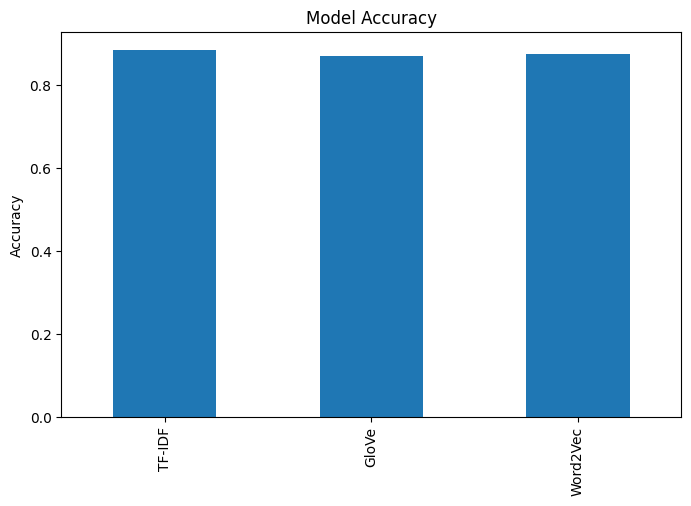

In [10]:
results = {
    "TF-IDF": metrics_tfidf,
    "GloVe": metrics_glove,
    "Word2Vec": metrics_w2v
}

df_results = pd.DataFrame(results).T
print(df_results)

# Plot accuracy
df_results["accuracy"].plot(kind="bar", figsize=(8, 5), title="Model Accuracy")
plt.ylabel("Accuracy")
plt.show()
